# **Imports**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np
import random
import os
import re

from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
BASE_DIR = "/kaggle/input/flickr-image-dataset/flickr30k_images"
WORK_DIR = "/kaggle/working"

os.listdir(BASE_DIR)

['flickr30k_images', 'results.csv']

# **Preprocessing**

## Working with the captions

In [3]:
# Reading the results file.
captions = pd.read_csv(f"{BASE_DIR}/results.csv", sep='|', names=['image_name', 'comment_number', 'comment'])

In [4]:
captions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158916 entries, 0 to 158915
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   image_name      158916 non-null  object
 1   comment_number  158916 non-null  object
 2   comment         158915 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


In [5]:
captions.describe()

,image_name,comment_number,comment
count,158916,158916,158915
unique,31784,7,158439
top,3631029759.jpg,0,Two dogs playing in the snow .
freq,5,31783,7


In [6]:
captions.isnull().sum()

image_name        0
comment_number    0
comment           1
dtype: int64

In [7]:
# Deleting null values
captions.dropna(inplace=True)

In [8]:
captions.isnull().sum()

image_name        0
comment_number    0
comment           0
dtype: int64

In [9]:
# mapping the images with their captions.
mapping = captions.groupby('image_name')['comment'].apply(list).to_dict()

# Remove column name for keys
del mapping['image_name']

In [10]:
samples = 5
for image, captions in list(mapping.items())[:samples]:
    print(image)
    for caption in captions:
        print(caption)
    print()
    

1000092795.jpg
 Two young guys with shaggy hair look at their hands while hanging out in the yard .
 Two young , White males are outside near many bushes .
 Two men in green shirts are standing in a yard .
 A man in a blue shirt standing in a garden .
 Two friends enjoy time spent together .

10002456.jpg
 Several men in hard hats are operating a giant pulley system .
 Workers look down from up above on a piece of equipment .
 Two men working on a machine wearing hard hats .
 Four men on top of a tall structure .
 Three men on a large rig .

1000268201.jpg
 A child in a pink dress is climbing up a set of stairs in an entry way .
 A little girl in a pink dress going into a wooden cabin .
 A little girl climbing the stairs to her playhouse .
 A little girl climbing into a wooden playhouse 
 A girl going into a wooden building .

1000344755.jpg
 Someone in a blue shirt and hat is standing on stair and leaning against a window .
 A man in a blue shirt is standing on a ladder cleaning a win

In [11]:
def clean_text(txt):

    if not txt:
        return ""

    txt = txt.lower()
    txt = re.sub(r'<.*?>', '', txt) # to remove html tags </>
    txt = re.sub(r'[^a-z ]', '', txt) # remove non-alpha character
    txt = re.sub(r'\s+', ' ', txt) # replace multiple spaces with single space
    txt = ' '.join([word for word in txt.split() if (len(word) > 1)]) # remove stop words
    
    return txt

In [12]:
for lst in mapping.values():
    for i in range(len(lst)):
        lst[i] = '<start> '+ clean_text(lst[i]) + ' <end>'

In [13]:
# Visualize
for cap in mapping['1000092795.jpg']:
    print(cap)

<start> two young guys with shaggy hair look at their hands while hanging out in the yard <end>
<start> two young white males are outside near many bushes <end>
<start> two men in green shirts are standing in yard <end>
<start> man in blue shirt standing in garden <end>
<start> two friends enjoy time spent together <end>


In [14]:
def generate_vocab(data):
    all_vocab = set()
    for lst in data.values():
        [all_vocab.update(caption.split()) for caption in lst]
    return all_vocab

vocabs = list(generate_vocab(mapping))
print(len(vocabs))

19749


In [15]:
# Split captoins to a list of tokens (words)
processed_captions = [ caption.split() for lst in mapping.values() for caption in lst ]

In [16]:
from gensim.models import Word2Vec

In [17]:
# Initialize Vectorizer
vectorizer = Word2Vec(
    sentences=processed_captions,
    vector_size=128,
    window=5,          # Captures context words effectively
    min_count=1,       # Removes infrequent words
    epochs=30,
)

In [18]:
for captions in mapping.values():
  for cap in captions:
     print(cap)
  break

print()

for cap in processed_captions[:5]:
  print(cap)

<start> two young guys with shaggy hair look at their hands while hanging out in the yard <end>
<start> two young white males are outside near many bushes <end>
<start> two men in green shirts are standing in yard <end>
<start> man in blue shirt standing in garden <end>
<start> two friends enjoy time spent together <end>

['<start>', 'two', 'young', 'guys', 'with', 'shaggy', 'hair', 'look', 'at', 'their', 'hands', 'while', 'hanging', 'out', 'in', 'the', 'yard', '<end>']
['<start>', 'two', 'young', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '<end>']
['<start>', 'two', 'men', 'in', 'green', 'shirts', 'are', 'standing', 'in', 'yard', '<end>']
['<start>', 'man', 'in', 'blue', 'shirt', 'standing', 'in', 'garden', '<end>']
['<start>', 'two', 'friends', 'enjoy', 'time', 'spent', 'together', '<end>']


In [19]:
# Vocabulary and its corresponding index
print(list(vectorizer.wv.key_to_index.items())[:5])

# Words
words = list(vectorizer.wv.key_to_index.keys())
print("Number of words:", len(words))
print("Sample:", words[:10])

[('<start>', 0), ('<end>', 1), ('in', 2), ('the', 3), ('on', 4)]
Number of words: 19749
Sample: ['<start>', '<end>', 'in', 'the', 'on', 'and', 'man', 'is', 'of', 'with']


In [20]:
# Test Similarity Performance
print(("Most Similar Words to a Word \"house\" : "))
for word, prob in vectorizer.wv.most_similar('house'):
    print(word, ':', prob)

print()

print("Most Similar Words to Word \"dog\" : ")
for key, value in vectorizer.wv.most_similar('dog'):
  print(key, value)

Most Similar Words to a Word "house" : 
building : 0.6957946419715881
shed : 0.6040775775909424
structure : 0.5622387528419495
storefront : 0.5549523830413818
fence : 0.5357797145843506
hut : 0.5266239643096924
door : 0.5244965553283691
fireplace : 0.5202875137329102
cathedral : 0.5162516236305237
van : 0.5128128528594971

Most Similar Words to Word "dog" : 
puppy 0.7827218174934387
poodle 0.7119054198265076
retriever 0.6390644907951355
dogs 0.637312114238739
collar 0.592598557472229
bird 0.5905983448028564
beagle 0.5695564150810242
shepherd 0.5613088607788086
spots 0.5589466691017151
terrier 0.5582813024520874


In [21]:
PADDING = max(len(caption) for caption in processed_captions)
print(PADDING)

74


## Preprocessing Images

In [22]:
# Creating images path
IMAGES_PATH = BASE_DIR + '/flickr30k_images'

len(os.listdir(IMAGES_PATH))

31785

In [23]:
# Showing first image.
first_image_path = IMAGES_PATH + '/' + os.listdir(IMAGES_PATH)[0]

image = Image.open(first_image_path)

print("Raw Image Dims:".ljust(25), image.size)

# Increasing the dimensions of the images.
image = np.array(image)
image = np.expand_dims(image, axis=0)

# Getting the shape of the image (1, width, height, channels)
print("Pre-Processed Image Dims:", image.shape)

Raw Image Dims:           (500, 333)
Pre-Processed Image Dims: (1, 333, 500, 3)


In [24]:
# Unify Image Dimensions
UNISHAPE = (256, 256)
def unify_shape(image, dims = UNISHAPE):
    # Stretch the image
    image = tf.image.resize(image, dims, method="bilinear")
    image = np.expand_dims(image, axis=0)
    
    # Normalize pixel values to [0, 1]
    image = image / 255.0

    return image

In [25]:
# Load images to the memory as numpy arrays
def preprocess_image(image):
    # Decode the image
    image = tf.image.decode_jpeg(image, channels=3)

    image = unify_shape(image)

    return image

In [26]:
image = tf.io.read_file(first_image_path)
preprocess_image(image)

array([[[[0.7086114 , 0.72037613, 0.69292516],
         [0.6761642 , 0.6812653 , 0.65714616],
         [0.6509804 , 0.6560815 , 0.6319623 ],
         ...,
         [0.6827516 , 0.71245   , 0.69588697],
         [0.6834482 , 0.7069776 , 0.69913447],
         [0.6778416 , 0.701371  , 0.6935279 ]],

        [[0.70942926, 0.7247326 , 0.6972816 ],
         [0.6786938 , 0.6904585 , 0.6630075 ],
         [0.6527497 , 0.6645144 , 0.63706344],
         ...,
         [0.6901961 , 0.7137255 , 0.7058824 ],
         [0.6801164 , 0.7036458 , 0.6993413 ],
         [0.6745098 , 0.69803923, 0.6937347 ]],

        [[0.709708  , 0.7293158 , 0.70186484],
         [0.678822  , 0.6964844 , 0.6690334 ],
         [0.6519531 , 0.6696155 , 0.6421645 ],
         ...,
         [0.6901961 , 0.7137255 , 0.71178   ],
         [0.68306524, 0.70659465, 0.70659465],
         [0.67745864, 0.69803923, 0.7068857 ]],

        ...,

        [[0.1655827 , 0.17716357, 0.173242  ],
         [0.14325215, 0.1648361 , 0.15796569]

# Visualization

In [27]:
def plot_image(image):    
    plt.imshow(image)
    plt.axis(False)
    plt.grid(False)
    plt.show()

In [28]:
def show_data_sample(data, images_folder_path, sample_size = 3):
    i = 0
    samples = random.sample(list(data.items()), sample_size)
    for image_name, captions in samples:
        image_path = images_folder_path + '/' + image_name
        
        image = tf.io.read_file(image_path)
        image_array = preprocess_image(image)
        plot_image(image_array[0])
        
        for caption in captions:
            print(caption)
        print('\n')
    

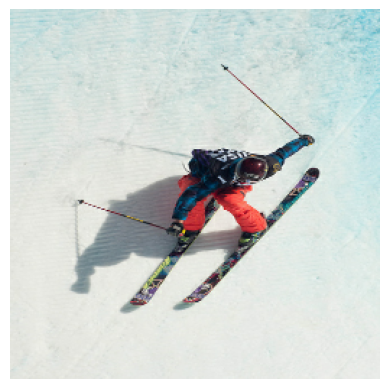

<start> person in orange pant skiing in an event sponsored by visa <end>
<start> person in orange pants is skiing down slope <end>
<start> skier in red pants skiing down slope <end>
<start> somebody is skiing down mountain <end>
<start> aerial view of competitive skier <end>




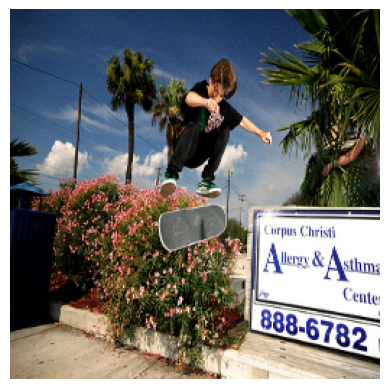

<start> the boy in black is skateboarding in the air in front of the flowers and white and blue sign <end>
<start> boy jumps high above his skateboard near sign <end>
<start> boy jumping skateboard beside sign and pink flowers <end>
<start> boy is doing skateboarding trick in the air <end>
<start> he is skateboarding <end>




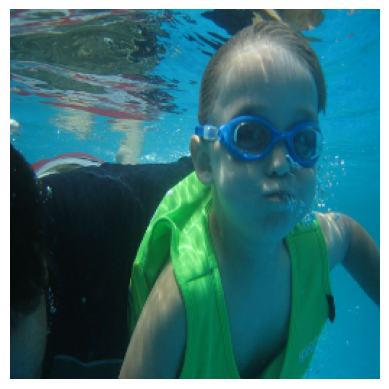

<start> blond child is wearing blue goggles and green speedo tank top while swimming underwater <end>
<start> girl in green speedo top and blue goggles holds her breath underwater <end>
<start> boy underwater with someone helping him to swim <end>
<start> child swimming underneath the water <end>
<start> child is swimming with goggles on <end>




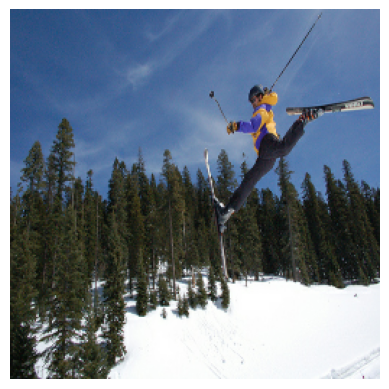

<start> skier splits his or her legs while flying throught the air over ski hill <end>
<start> skier is performing trick high in the air over snowy area <end>
<start> the skier is jumping high above the snow <end>
<start> man in blue an yellow coat ski jumps <end>
<start> person jumping down hill on skis <end>




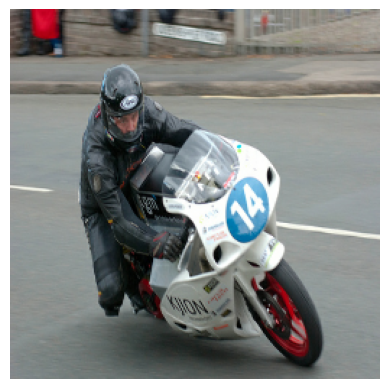

<start> man dressed in black dramatically rides racing motorcycle along stretch of street pavement <end>
<start> the man dressed in black racing gear is leaning into sharp turn on his motorcycle <end>
<start> man in black wearing protective headgear speeds around corner on motorcycle <end>
<start> man on motorcycle taking sharp left turn <end>
<start> guy in black is riding white motorcycle <end>




In [29]:
random.seed(432543)
show_data_sample(mapping, IMAGES_PATH, 5)

In [30]:
# create dataframe using vocabulary | tokens
# number of column = vector_size = 128
df = pd.DataFrame(vectorizer.wv[words],index=words)
print(df.shape)
df.head()

(19749, 128)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
<start>,2.769154,1.766339,-5.364885,2.010057,0.725429,0.913127,1.064032,-0.441277,-1.933644,0.526618,...,0.959255,0.144138,1.421067,0.562466,0.307430,-2.259551,2.082773,-1.748357,1.131170,-0.285718
<end>,-0.106470,2.461113,-2.861651,-0.584082,0.612828,-0.003343,1.208404,0.079509,1.668528,-0.626587,...,0.883286,-1.529860,0.213387,0.546971,0.658473,-0.033456,-0.355506,-1.003815,0.502904,-0.897343
in,2.691194,-0.819153,-2.705469,-0.001789,0.371484,0.970401,0.533816,-0.696019,-0.057931,0.087226,...,1.585073,0.037691,1.564997,1.633815,-0.892516,1.229591,-0.166600,0.231921,0.627812,-0.832008
the,1.117830,2.095705,-0.690782,1.158530,-0.199914,-0.640272,0.693455,-0.550301,0.889634,-0.036772,...,0.270100,-1.125543,-0.132806,1.232371,1.219506,1.162447,0.475485,-1.567866,0.182947,-0.380732
on,-0.652342,0.977180,-1.003422,-0.837952,-0.298350,-1.870232,2.834697,-1.058717,-1.806630,0.982998,...,0.901338,1.754660,-0.039577,1.354519,1.014950,1.923026,1.548196,-0.802468,-0.724825,-0.384602


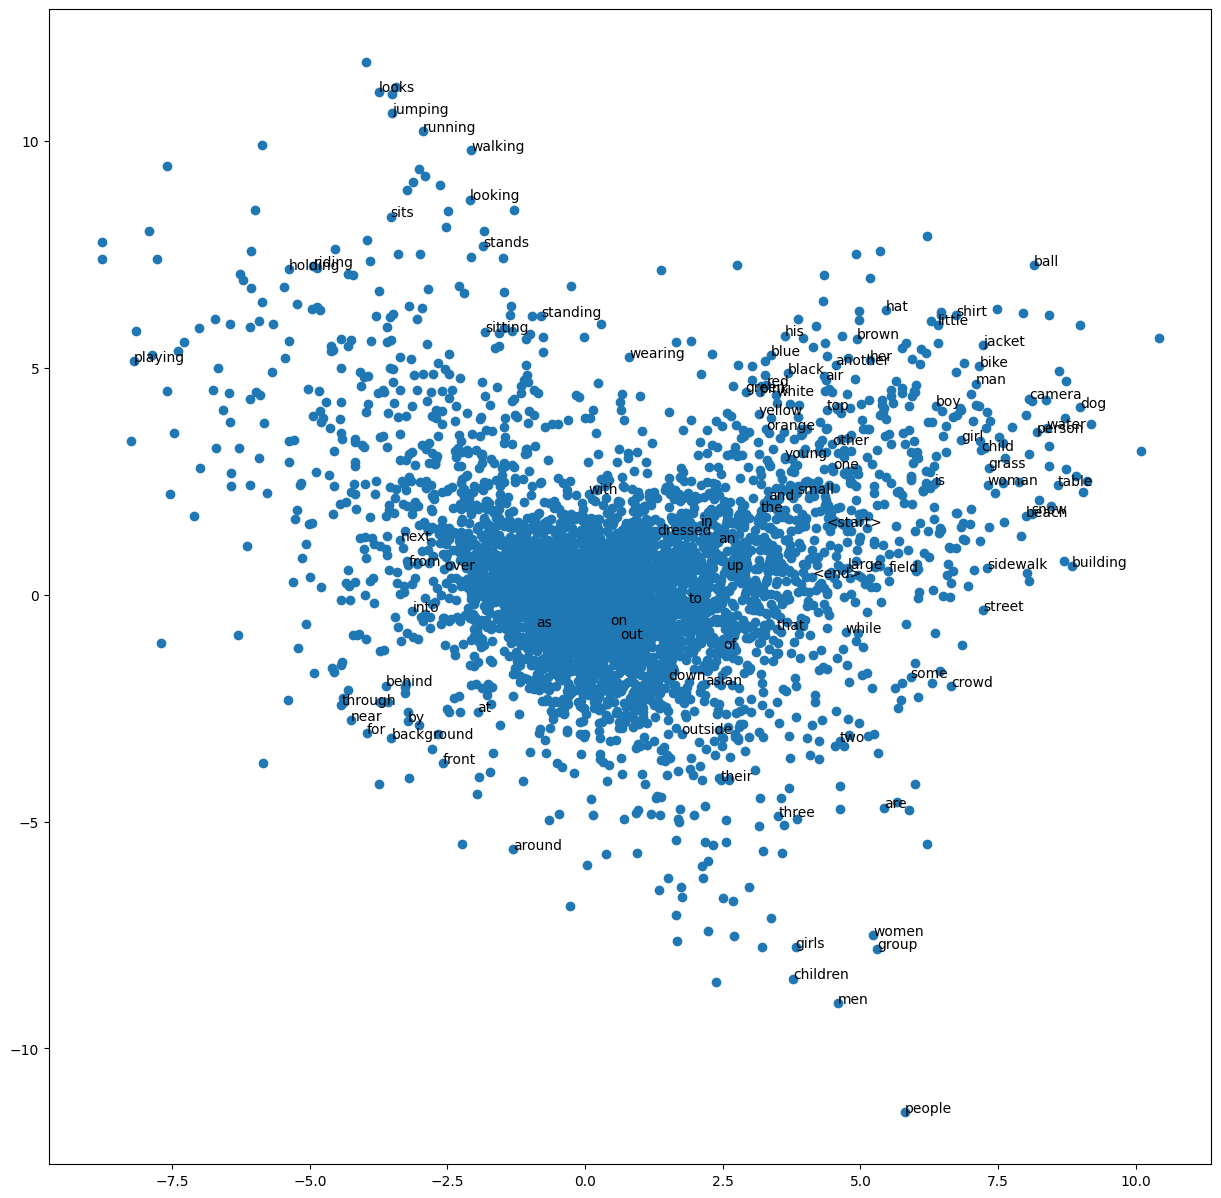

In [31]:
# Words numerical visualization
from sklearn.decomposition import PCA

plt.figure(figsize=(15, 15))
pca = PCA(n_components=2)
x = vectorizer.wv[words]
result = pca.fit_transform(x)
words = list(vectorizer.wv.key_to_index)
plt.scatter(result[:, 0],result[:, 1])
for i, word in enumerate(words[:100]): # change range
      plt.annotate(word, xy =(result[i, 0], result[i, 1]))
plt.show()

# Preparing Data

In [32]:
def make_word_to_index(vectorizer):
    # Word to index mapping
    word_to_index = {word: idx + 1 for idx, word in enumerate(vectorizer.wv.key_to_index.keys())}

    return word_to_index

In [33]:
def prepare_images_and_captions(image_folder_path, mapping, vectorizer):
    """
    Prepares images and captions for model training:
    - Resizes images to (256, 256) and normalizes pixel values.
    - Converts captions to numerical sequences using Word2Vec.
    - Pads captions to a fixed length.

    Returns:
    - processed_images: Dictionary {image_name: normalized_image_array}
    - padded_captions: Dictionary {image_name: padded_numerical_captions}
    """
    # Initialize containers
    processed_images = []
    padded_captions = []

    word_to_index = make_word_to_index(vectorizer)
    
    # Load all images:
    for image_name, captions in tqdm(mapping.items()):
        # Get Image Path
        image_path = image_folder_path + '/' + image_name
        
        # Read and Pre-process image
        image = tf.io.read_file(image_path)
        processed_images.append(preprocess_image(image))
        
        # Convert captions to numerical sequences
        caption = captions[0]
        numerical_captions = [[word_to_index[word] for word in caption.split() if word in word_to_index]]

        # Pad Numerical Sequence
        padded_captions.append(pad_sequences(numerical_captions, maxlen=PADDING, padding='post'))

    return processed_images, padded_captions

In [34]:
processed_images, padded_captions = prepare_images_and_captions(IMAGES_PATH, mapping, vectorizer)

100%|██████████| 31783/31783 [06:18<00:00, 84.04it/s]


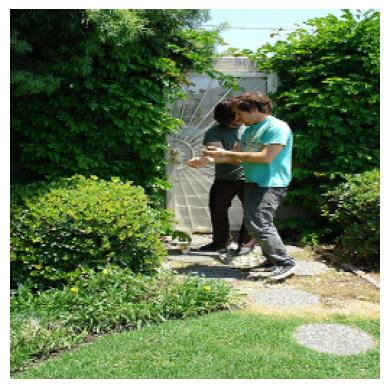

[   1   12   19  321   10 2115  107  183   16   61  155   23  320   71
    3    4  485    2    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]




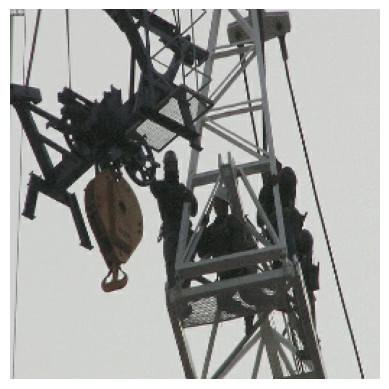

[   1  116   29    3  327  271   13 1309  811 3845 2625    2    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]




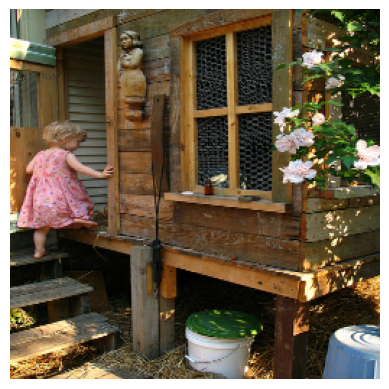

[   1   48    3   85  113    8  241   47  356    9  403    3   17 5337
  649    2    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]




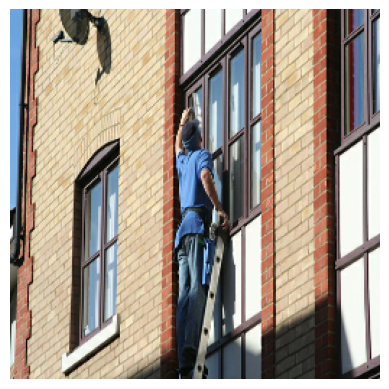

[   1  275    3   25   21    6   62    8   31    5 2862    6  362  222
  230    2    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]




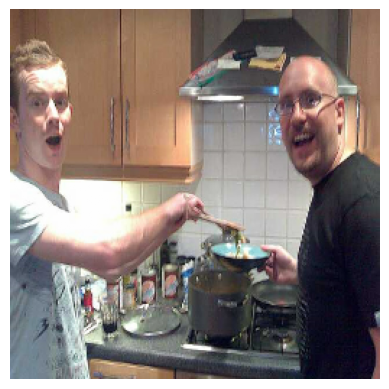

[   1   12   29   41    3  117   21   41    3   22   21   31   79 1397
    2    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]




In [37]:
i = 0
for captions, image in zip(padded_captions, processed_images):
    plot_image(image[0])
    for caption in captions:
        print(caption)
    print('\n')
    i += 1
    if i == 5:
        break

# Data Splitting

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
x_train, x_test, y_train, y_test = train_test_split(processed_images, padded_captions, train_size= 0.6, random_state= 42)
x_cv, x_test, y_cv, y_test = train_test_split(x_test, y_test, train_size= 0.5, random_state= 42)

In [43]:
print(len(x_train), len(x_cv), len(x_test))
print(x_train[0].shape, x_cv[0].shape, x_test[0].shape)
print(len(y_train), len(y_cv), len(y_test))
print(y_train[0].shape, y_cv[0].shape, y_test[0].shape)

19069 6357 6357
(1, 256, 256, 3) (1, 256, 256, 3) (1, 256, 256, 3)
19069 6357 6357
(1, 74) (1, 74) (1, 74)


# Buliding The Model